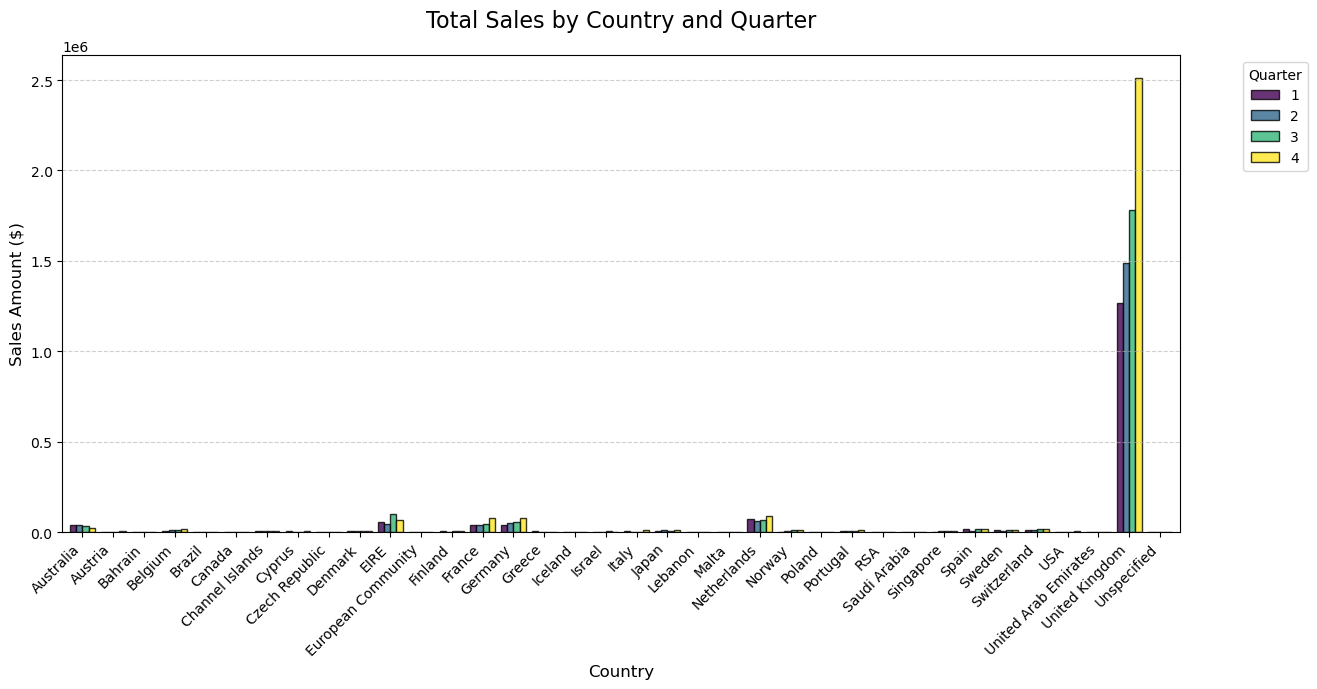

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to your SQLite DW
conn = sqlite3.connect("retail_dw.db")

# Roll-up query
query = """
SELECT 
    sf.Country,
    td.Quarter,
    SUM(sf.TotalSales) AS TotalSales
FROM SalesFact sf
JOIN TimeDim td 
    ON sf.InvoiceDate = td.InvoiceDate
GROUP BY sf.Country, td.Quarter
ORDER BY sf.Country, td.Quarter;
"""
df = pd.read_sql_query(query, conn)

# Pivot for plotting
pivot_df = df.pivot(index='Country', columns='Quarter', values='TotalSales')

import matplotlib.pyplot as plt

# Plot
ax = pivot_df.plot(kind='bar', 
                   figsize=(12, 7), 
                   width=0.8,          # Adjust bar width
                   edgecolor='black',   # Add borders to bars
                   alpha=0.8,          # Transparency
                   colormap='viridis') # Color scheme

# Customize title and labels
plt.title("Total Sales by Country and Quarter", fontsize=16, pad=20)
plt.ylabel("Sales Amount ($)", fontsize=12)
plt.xlabel("Country", fontsize=12)

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha='right')  # Align labels to the right after rotation
plt.tight_layout()

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and show
plt.savefig("sales_by_country_quarter.png", dpi=300, bbox_inches='tight')
plt.show()

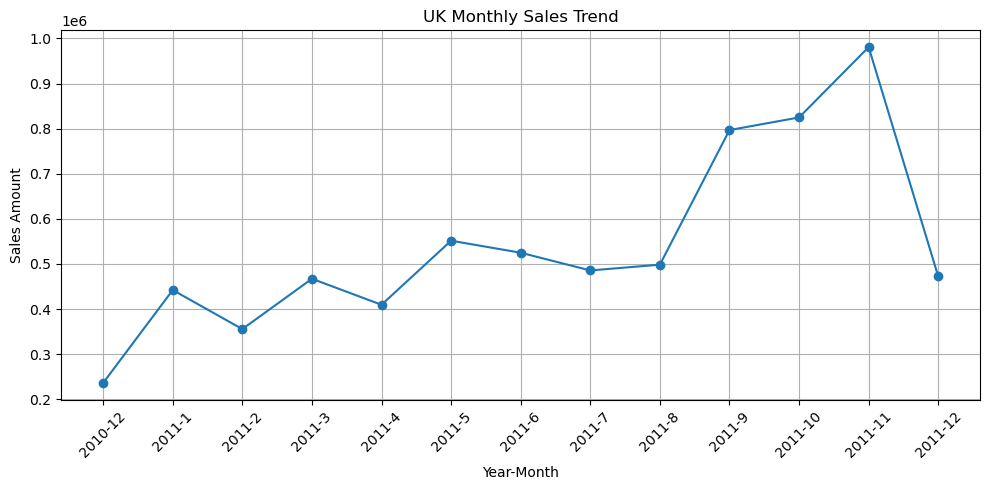

In [2]:
drill_query = """
SELECT 
    td.Year,
    td.Month,
    SUM(sf.TotalSales) AS TotalSales
FROM SalesFact sf
JOIN TimeDim td 
    ON sf.InvoiceDate = td.InvoiceDate
WHERE sf.Country = 'United Kingdom'
GROUP BY td.Year, td.Month
ORDER BY td.Year, td.Month;
"""
df_drill = pd.read_sql_query(drill_query, conn)
df_drill['YearMonth'] = df_drill['Year'].astype(str) + '-' + df_drill['Month'].astype(str)

plt.figure(figsize=(10,5))
plt.plot(df_drill['YearMonth'], df_drill['TotalSales'], marker='o')
plt.title("UK Monthly Sales Trend")
plt.xlabel("Year-Month")
plt.ylabel("Sales Amount")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("uk_sales_trend.png")
plt.show()

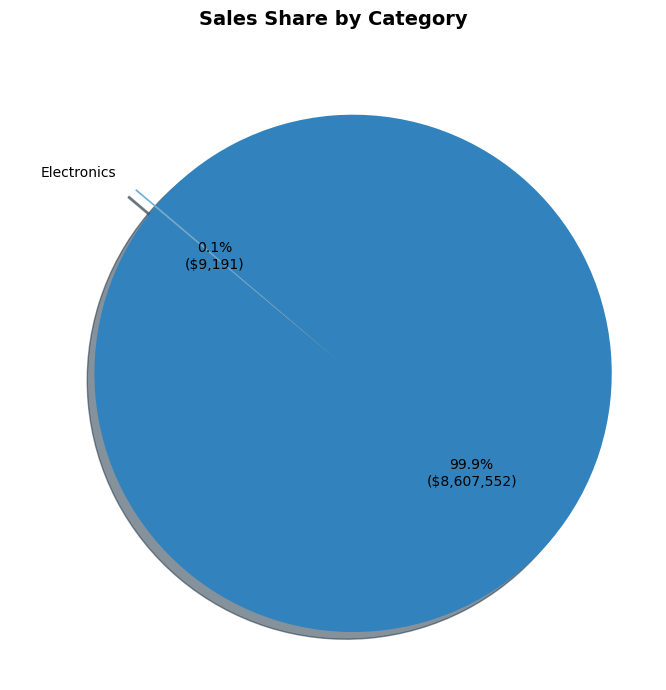

In [3]:
# Query: Total sales per category
category_query = """
SELECT Category, SUM(TotalSales) AS TotalSales
FROM SalesFact
GROUP BY Category;
"""
df_cat = pd.read_sql_query(category_query, conn)

# Sort categories by total sales (descending)
df_cat = df_cat.sort_values(by="TotalSales", ascending=False)

# Define colors (optional: can use seaborn/matplotlib palettes)
colors = plt.cm.tab20c.colors  # Nice category palette

# Create explode array (highlight the biggest category)
explode = [0.1] + [0 for _ in range(len(df_cat)-1)]

# Custom autopct to show both percentage & value
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.1f}%\n(${absolute:,})"

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(
    df_cat["TotalSales"], 
    labels=df_cat["Category"], 
    autopct=lambda pct: autopct_format(pct, df_cat["TotalSales"]),
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title("Sales Share by Category", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("sales_share_by_category.png", dpi=300)
plt.show()


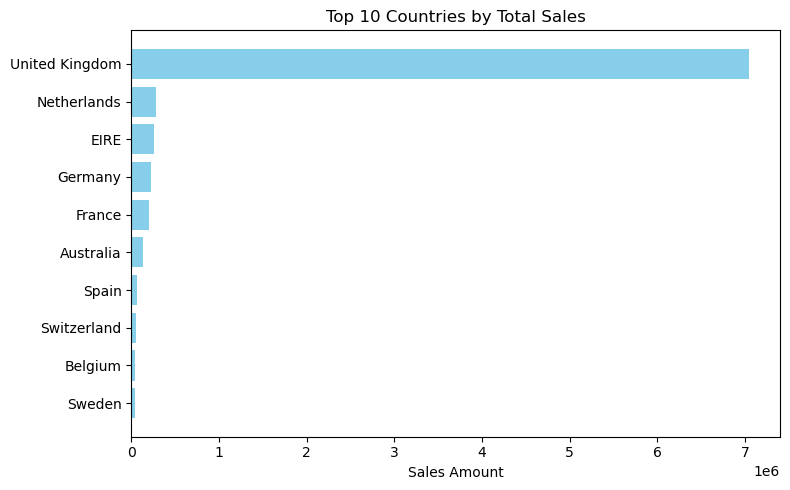

In [4]:
top_countries_query = """
SELECT Country, SUM(TotalSales) AS TotalSales
FROM SalesFact
GROUP BY Country
ORDER BY TotalSales DESC
LIMIT 10;
"""
df_top = pd.read_sql_query(top_countries_query, conn)

plt.figure(figsize=(8,5))
plt.barh(df_top['Country'], df_top['TotalSales'], color='skyblue')
plt.title("Top 10 Countries by Total Sales")
plt.xlabel("Sales Amount")
plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.savefig("top_10_countries.png")
plt.show()

In [5]:
conn.close()